# Comparison between exploratory techniques on the example of 10-armed bandit

Import environment and necessary libraries.
Initialize rewards, total rewards, epsilon and episodes

In [1]:
import gym
import gym_n_bandit
import numpy as np
from math import e

%matplotlib inline
import matplotlib.pyplot as plt

random_reward_list = []
epsilon_reward_list = []
softmax_reward_list = []
ucb_reward_list = []
thompson_reward_list = []

random_total_reward = 0
epsilon_total_reward = 0
softmax_total_reward = 0
ucb_total_reward = 0
thompson_total_reward = 0

epsilon = 0.1
max_episodes = 1000
smoothening = 50

Random agent
*a = random(**|s)

In [2]:
env = gym.make("NArmedBandit-v0")

table_q = np.zeros(env.action_space.n)
table_n = np.ones(env.action_space.n)
env.render()

for episode in np.arange(max_episodes):
    env.reset()
    action = env.action_space.sample()
    _, reward, _, _ = env.step(action)
    table_q[action] = table_q[action] + (reward-table_q[action])/table_n[action]
    table_n[action]+=1
    
    random_reward_list.append((episode, reward))
    random_total_reward+=reward

The true mean of rewards:
0.978 -0.175 -0.888 -0.863 -0.581 0.154 -0.565 -0.398 0.384 2.828 


Epsilon greedy exploration:<br>

with probability epsilon :
$$a = random(0, b)$$
with probability 1-epsilon:
$$a = argmax_aQ(a)$$

In [3]:
table_q = np.zeros(env.action_space.n)
table_n = np.ones(env.action_space.n)

for episode in np.arange(max_episodes):
    env.reset()
    if np.random.random() < epsilon:
        action = env.action_space.sample()
    else:
        action = np.argmax(table_q)
    _, reward, _, _ = env.step(action)
    table_q[action] = table_q[action] + (reward-table_q[action])/table_n[action]
    table_n[action]+=1
    
    epsilon_reward_list.append((episode, reward))
    epsilon_total_reward +=reward

Softmax agent<br>
Choose action randomly from a probability distribution:
$$ P(a) = \dfrac{e^{Q(a)}}{\sum_{a^\prime=0}^{a^\prime=b}e^{Q(a^\prime)}}$$


In [4]:
table_q = np.zeros(env.action_space.n)
table_n = np.ones(env.action_space.n)

for episode in np.arange(max_episodes):
    env.reset()
    probabilities = np.exp(table_q)/(np.sum(np.exp(table_q),axis=0))
    action = np.random.choice(env.action_space.n, p=probabilities)
    _, reward, _, _ = env.step(action)
    table_q[action] = table_q[action] + (reward-table_q[action])/table_n[action]
    table_n[action]+=1
    
    softmax_reward_list.append((episode, reward))
    softmax_total_reward +=reward

UCB agent<br>
Each time an action is chosen by:
$$a = argmax_a(Q(a)+2\sqrt{\dfrac{\ln t}{N(a)}}$$

In [5]:
table_q = np.zeros(env.action_space.n)
table_n = np.ones(env.action_space.n)
table_ucb = np.zeros(env.action_space.n)

for episode in range(1,max_episodes):
    env.reset()
    table_ucb = table_q + 2*(np.sqrt((np.log(episode))/table_n))
    action = np.argmax(table_ucb)
    _, reward, _, _ = env.step(action)
    table_q[action] = table_q[action] + (reward-table_q[action])/table_n[action]
    table_n[action]+=1
    
    ucb_reward_list.append((episode, reward))
    ucb_total_reward +=reward

Thompson agent<br>
Each time an action is chosen by:
$$a = argmax_aBeta(\alpha_a,\beta_a)$$
with:<br>
$$\alpha_a=\alpha_a+1\quad\textrm{if}\quad r>0$$
$$\beta_a=\beta_a+1\quad\textrm{if}\quad r<=0$$

In [6]:
table_q = np.zeros(env.action_space.n)
table_n = np.ones(env.action_space.n)
alpha_a = np.ones(env.action_space.n)
beta_a = np.ones(env.action_space.n)

for episode in np.arange(max_episodes):
    env.reset()
    theta = np.random.beta(alpha_a+1,beta_a+1)
    action = np.argmax(theta)
    _, reward, _, _ = env.step(action)
    
    table_q[action] = table_q[action] + (reward-table_q[action])/table_n[action]
    table_n[action]+=1
    
    if reward>0:
        alpha_a[action]+=1
    else:
        beta_a[action]+=1
    
    thompson_reward_list.append((episode, reward))
    thompson_total_reward +=reward
    

Visualize the data

Text(0,0.5,'Reward')

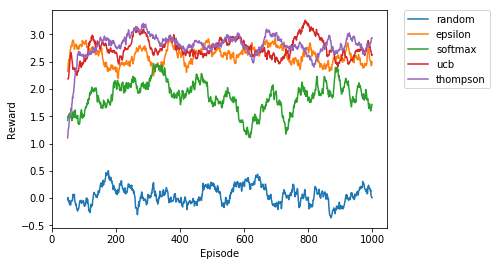

In [7]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

eps, rews = np.array(random_reward_list).T
random_smoothed_rews = running_mean(rews, smoothening)

eps, rews = np.array(epsilon_reward_list).T
epsilon_smoothed_rews = running_mean(rews, smoothening)

eps, rews = np.array(softmax_reward_list).T
softmax_smoothed_rews = running_mean(rews, smoothening)

eps, rews = np.array(ucb_reward_list).T
ucb_smoothed_rews = running_mean(rews, smoothening)

eps, rews = np.array(thompson_reward_list).T
thompson_smoothed_rews = running_mean(rews, smoothening)

plt.plot(eps[-len(random_smoothed_rews):], random_smoothed_rews, label='random')
plt.plot(eps[-len(epsilon_smoothed_rews):], epsilon_smoothed_rews, label='epsilon')
plt.plot(eps[-len(softmax_smoothed_rews):], softmax_smoothed_rews, label='softmax')
plt.plot(eps[-len(ucb_smoothed_rews):], ucb_smoothed_rews, label='ucb')
plt.plot(eps[-len(thompson_smoothed_rews):], thompson_smoothed_rews, label='thompson')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.xlabel('Episode')
plt.ylabel('Reward')

In [8]:
print("Total rewards")
print('{:10} {:.3f}'.format("Random:", random_total_reward))
print('{:10} {:.3f}'.format("Epsilon:", epsilon_total_reward))
print('{:10} {:.3f}'.format("Softmax:", softmax_total_reward))
print('{:10} {:.3f}'.format("UCB:", ucb_total_reward))
print('{:10} {:.3f}'.format("Thompson:", thompson_total_reward))


Total rewards
Random:    51.192
Epsilon:   2600.587
Softmax:   1842.213
UCB:       2715.147
Thompson:  2739.773
